# intro

The purpose of this notebook create the J terms for a single map grid cell at the surface, show the residuals and look at the comparable contributions of different terms

# packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
import warnings
warnings.filterwarnings('ignore')

# read grid and files

In [3]:
# define basin we want
iB = 6   # see mskBasin if you want for later; maybe we should write this to file
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [4]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [5]:
bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

In [6]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Salt'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'SEAICEheatConsFix': 0,
    'conserveTr': 0,
    'seaice_variable_salinity_flag': 0
}

In [7]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [8]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(50,) (50, 1350, 270)


In [9]:
#mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

hf1 (1350, 270)


In [10]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

In [11]:
# read one basin or whole ASTE
whole = False
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
if whole:
    mask = (mymsk < 5) | (mymsk==6) 
else:
    mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


## Get the timesteps

In [12]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2014"] = np.arange(3,5,1)
# times["2014"] = np.arange(9,11,1)
# times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

In [13]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

In [14]:
# ocean and ice
AB_gT=0
AB_gS=0

# create the salt budget
### salt tendency

In [15]:
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt    # PSU.m/s

In [16]:
tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)    # kg/m^3 * PSU.m/s * m^2 = g/s
budgO = {}
budgO['saltfluxes'] = {}
budgI = {}
budgI['saltfluxes'] = {}
budgOI = {}

# ocean

budgO['saltfluxes']['tend'] = tmptend
budgO['salttend'] = np.nansum(tmptend,axis=0)

### salt h conv

In [17]:
# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = myparms['rhoconst'] * (ADVx_SLT + DFxE_SLT)
tmpVo = myparms['rhoconst'] * (ADVy_SLT + DFyE_SLT)

# reshape and get the faces
tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['saltfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['salthconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo,axis=0),np.nansum(tmpVo,axis=0))

In [18]:
# also do hconv for ADV and DF
tmpUo = get_aste_faces(ADVx_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

tmpUo = get_aste_faces(DFxE_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

In [19]:
# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF","DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVxHEFF.reshape(ny,nx)
DFxEHEFF = DFxEHEFF.reshape(ny,nx)
DFyEHEFF = DFyEHEFF.reshape(ny,nx)
    
if myparms['seaice_variable_salinity_flag'] == 0:
    SIsal0 = myparms['SIsal0']

tmpUi = SIsal0 * myparms['rhoi'] * (DFxEHEFF + ADVxHEFF)
tmpVi = SIsal0 * myparms['rhoi'] * (DFyEHEFF + ADVyHEFF)
tmpUi = get_aste_faces(tmpUi,nfx,nfy)              
tmpVi = get_aste_faces(tmpVi,nfx,nfy)

budgI['salthconv'] = calc_UV_conv_mod(nfx,nfy,tmpUi, tmpVi)
budgOI['salthconv'] = (budgO['salthconv'] + budgI['salthconv'])

### salt v convergence

In [20]:
# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)

In [21]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

In [22]:
if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['saltzconv'] = SFLUX + oceSPflx                  # W/m^2
zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s
budgI['saltzconv'] = -budgO['saltzconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['saltzconv'] = budgO['saltzconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['saltzconv']=-oceSflux

In [42]:
nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']           # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']           # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # g/s 

print(trWtop.shape)
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
sptop = sptop * RAC3        # g/s

trWtop[1:,:,:] = trWtop[1:,:,:] + sptop[:-1,:,:]
trWtop[0,:,:] = budgO['saltzconv'] * RAC    # g/s top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO['saltfluxes']['trWtop'] = trWtop     # g/s
budgO['saltfluxes']['trWbot'] = trWbot     # g/s

budgI['saltfluxes']['trWtop'] = -RAC*0
budgI['saltfluxes']['trWbot'] = budgO['saltfluxes']['trWtop'][0,:,:]  # surface because ice

budgO['saltfluxes']['zconv'] = budgO['saltfluxes']['trWtop'] - budgO['saltfluxes']['trWbot']
budgO['saltzconv'] = RAC * budgO['saltzconv']   # g/s
budgI['saltzconv'] = RAC * budgI['saltzconv']   # g/s
budgOI['saltzconv'] = budgO['saltzconv'] + budgI['saltzconv']

(50, 1350, 270)


In [24]:
# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Sconv = budgO['saltfluxes']['ADV_hconv'] + tmpadv
budgO['saltfluxes']['ADV_Sconv'] = Sconv             # g/s, this is the advective arrow of S for a cell

In [25]:
# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfSconv = budgO['saltfluxes']['DF_hconv'] + tmpdf
budgO['saltfluxes']['DF_Sconv'] = dfSconv             # g/s, this is the diffusive arrow of T for a cell

In [26]:
tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['saltfluxes']['KPP_Sconv'] = tmpkpp        # no horizontal component for this

### show salt is budgeted

In [27]:
# pick one point from face 3 and one point from face 1
pt = np.array([[10,500,4],       # this is organized as x,y,z
               [220,445,10]])

pt = np.array([[10,500,4],       # this is organized as x,y,z
               [100,600,10]])

# 0 540 50
pt = np.array([[50,540,4],       # this is organized as x,y,z
               [100,600,10]])

y,x = 540,50

pt = np.array([[50,540,0],
               [25,500,0]])      # first is an extreme point, second is a more "normal" or midrange point for 03/2014

In [28]:
# Data variables (as given in your initial code)
a = budgO['saltfluxes']['tend']
b = budgO['saltfluxes']['ADV_Sconv']
c = budgO['saltfluxes']['DF_Sconv']
d = budgO['saltfluxes']['KPP_Sconv']
e = zconv_top_salt.reshape(1,ny,nx)                 # only at surface, is the surface forcing  ((SFLUX + oceSPflx) * RAC) in g/s
f = sptop                                            # oceSPtnd contribution from the ice

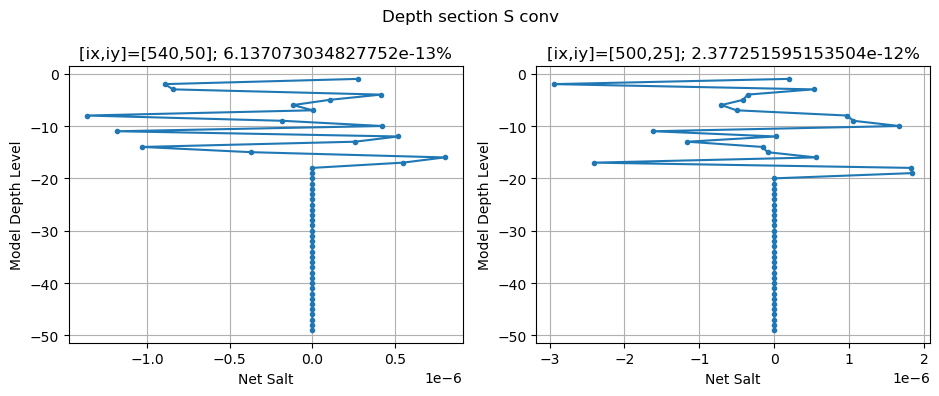

In [29]:
# also show the convergence at depth - I will make this a 1 by 2 plot so I can look at things easier

plt.figure(figsize=(9.5, 4))

aa = np.zeros((nz, 2))
plt.suptitle("Depth section S conv")


n = 1
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[1:, n-1] += (f[1:,iy,ix] - f[:-1,iy,ix])                                  # from the oceSPflx and oceSPtnd
aa[0, n-1] += f[0,iy,ix]
aa[0, n-1] -= zconv_top_salt[iy, ix]
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['saltfluxes']['zconv'][:,iy, ix]))}%")

n = 2
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[1:, n-1] += (f[1:,iy,ix] - f[:-1,iy,ix])                                  # from the oceSPflx and oceSPtnd
aa[0, n-1] += f[0,iy,ix]
aa[0, n-1] -= zconv_top_salt[iy, ix]

plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['saltfluxes']['zconv'][:,iy, ix]))}%")
    
        
plt.tight_layout()
plt.show()

# we want to derive a fraction for salt as we have done for temperature

In [32]:
ix, iy, k = pt[0]

sptop[:,iy,ix]

array([ 3.18692128e+04,  3.18687843e+04,  3.18658679e+04,  3.18550730e+04,
        3.18260333e+04,  3.17617478e+04,  3.16369225e+04,  3.14160285e+04,
        3.10512439e+04,  3.04766424e+04,  2.95952370e+04,  2.82440131e+04,
        2.61106565e+04,  2.25578566e+04,  1.62125386e+04,  4.03243615e+03,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12])

In [43]:
dd = mygrid['RF'][:-1]  # Depth of the cell faces (ignore the last one)

# Define spfrac using a similar approach as swfrac, but customized for salinity
spfrac = 0.5 * np.exp(dd / 0.8) + 0.5 * np.exp(dd / 15)  # Adjust these parameters as needed
spfrac[dd < -150] = 0  # Set a depth threshold if necessary

# Calculate sptop without cumsum using spfrac
sptoptest = mk3D_mod(spfrac, trWtop) * mk3D_mod(oceSPflx, trWtop)  # g/s
sptoptest[:,iy,ix]

array([1.55001775e-04, 3.97905713e-05, 2.04290122e-05, 1.04886046e-05,
       5.38502915e-06, 2.76476615e-06, 1.41947827e-06, 7.28784445e-07,
       3.73921046e-07, 1.91593895e-07, 9.76488619e-08, 4.90763870e-08,
       2.38880421e-08, 1.09067079e-08, 4.45804949e-09, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [44]:
from scipy.optimize import curve_fit

def spfrac_func(dd, a1, b1, a2, b2):
    return a1 * np.exp(dd / b1) + a2 * np.exp(dd / b2)

popt, _ = curve_fit(spfrac_func, depth, sptop_original.mean(axis=(1, 2)))
spfrac = spfrac_func(depth, *popt)


In [48]:
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac

array([1.00000000e+000, 2.30481687e-001, 1.39794188e-001, 8.47894609e-002,
       5.14274076e-002, 3.11922995e-002, 1.89190860e-002, 1.14750057e-002,
       6.95646368e-003, 4.21298428e-003, 2.54128854e-003, 1.51690375e-003,
       8.83973011e-004, 4.90991360e-004, 2.50993372e-004, 1.12553260e-004,
       4.17803666e-005, 1.20603900e-005, 2.54702633e-006, 3.73038567e-007,
       3.64769958e-008, 2.33189633e-009, 9.74595178e-011, 2.71947022e-012,
       5.26250567e-014, 7.45047256e-016, 8.20257105e-018, 7.47540153e-020,
       5.97621856e-022, 4.39495901e-024, 3.07445728e-026, 2.07051750e-028,
       1.30534681e-030, 7.00219760e-033, 2.67752866e-035, 5.76122144e-038,
       5.49811214e-041, 1.94480179e-044, 2.30251139e-048, 8.75325737e-053,
       1.05629370e-057, 4.03609174e-063, 4.88313480e-069, 1.87067242e-075,
       2.26912342e-082, 8.71524981e-090, 1.05989516e-097, 4.08138271e-106,
       4.97637477e-115, 1.92123365e-124])

In [62]:
np.cumsum(oceSPtnd, axis=0)[:,iy,ix]

array([6.72251613e-11, 2.15120516e-09, 1.63357142e-08, 6.88385652e-08,
       2.10078629e-07, 5.22742855e-07, 1.12985329e-06, 2.20421120e-06,
       3.97840768e-06, 6.77308649e-06, 1.10599617e-05, 1.76318849e-05,
       2.80078524e-05, 4.52875403e-05, 7.61491476e-05, 1.35389289e-04,
       1.55001775e-04, 1.55001775e-04, 1.55001775e-04, 1.55001775e-04,
       1.55001775e-04, 1.55001775e-04, 1.55001775e-04, 1.55001775e-04,
       1.55001775e-04, 1.55001775e-04, 1.55001775e-04, 1.55001775e-04,
       1.55001775e-04, 1.55001775e-04, 1.55001775e-04, 1.55001775e-04,
       1.55001775e-04, 1.55001775e-04, 1.55001775e-04, 1.55001775e-04,
       1.55001775e-04, 1.55001775e-04, 1.55001775e-04, 1.55001775e-04,
       1.55001775e-04, 1.55001775e-04, 1.55001775e-04, 1.55001775e-04,
       1.55001775e-04, 1.55001775e-04, 1.55001775e-04, 1.55001775e-04,
       1.55001775e-04, 1.55001775e-04])

In [47]:
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
sptop = sptop * RAC3        # g/s
sptop[:,iy,ix]

array([ 3.18692128e+04,  3.18687843e+04,  3.18658679e+04,  3.18550730e+04,
        3.18260333e+04,  3.17617478e+04,  3.16369225e+04,  3.14160285e+04,
        3.10512439e+04,  3.04766424e+04,  2.95952370e+04,  2.82440131e+04,
        2.61106565e+04,  2.25578566e+04,  1.62125386e+04,  4.03243615e+03,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12])

In [72]:
spfrac = 0.62*np.exp(dd/0.6) +(1-0.62)*np.exp(dd/20)
# print(spfrac)
oceSPreplicate = mk3D_mod(spfrac,trWtop) * oceSPtnd
sptop = mk3D_mod(oceSPflx,oceSPtnd) + oceSPreplicate
sptop = sptop * RAC3        # g/s
sptop[:,iy,ix]

array([31869.24043892, 31869.32537336, 31869.63431477, 31870.14190894,
       31870.72005572, 31871.23182971, 31871.58819725, 31871.7613765 ,
       31871.76422828, 31871.64740413, 31871.46652243, 31871.27629371,
       31871.11244671, 31870.97101111, 31870.81924982, 31870.59752729,
       31869.39509372, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706])

In [67]:
# Modify these parameters
alpha = 0.7  # Adjusted weight
scale1 = 0.5  # Adjusted decay rate for the first exponential term
scale2 = 15   # Adjusted decay rate for the second exponential term

# Calculate the modified spfrac
spfrac = alpha * np.exp(dd / scale1) + (1 - alpha) * np.exp(dd / scale2)
oceSPreplicate = mk3D_mod(spfrac, trWtop) * oceSPtnd
sptop = mk3D_mod(oceSPflx, oceSPtnd) - oceSPreplicate
sptop = sptop * RAC3  # g/s

# Test the result at the desired location
sptop[:, iy, ix]

array([31869.21279519, 31869.16062069, 31868.99598955, 31868.78833869,
       31868.6212826 , 31868.53862088, 31868.54074063, 31868.60346001,
       31868.69862054, 31868.80046656, 31868.89345352, 31868.96992378,
       31869.02934817, 31869.07662129, 31869.11711737, 31869.15447229,
       31869.22024509, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706, 31869.22661706, 31869.22661706,
       31869.22661706, 31869.22661706])

In [56]:
from scipy.optimize import curve_fit
import numpy as np

# Step 1: Calculate the original sptop using cumsum
sptop_original = mk3D_mod(oceSPflx, oceSPtnd) - np.cumsum(oceSPtnd, axis=0)
sptop_original = sptop_original * RAC3  # g/s

# Step 2: Define depth and calculate the mean sptop profile across x and y dimensions
depth = mygrid['RF'][:-1]  # Assuming depth is positive going downward
sptop_profile = sptop_original.mean(axis=(1, 2))  # Average over horizontal dimensions

# Step 3: Define an exponential function to fit
def exp_decay(dd, scale_depth):
    return np.exp(dd / scale_depth)

# Step 4: Fit the function to the data
popt, _ = curve_fit(exp_decay, depth, sptop_profile, p0=100)  # Initial guess for scale_depth

# Step 5: Extract the fitted scale_depth
scale_depth = popt[0]
print(f"Estimated scale_depth: {scale_depth}")

# Step 6: Calculate spfrac using the estimated scale_depth
scale_depth = 13200000
spfrac = np.exp(depth / scale_depth)
spfrac /= spfrac[0]  # Normalize so that spfrac[0] = 1

# Optionally, apply a depth cutoff
spfrac[depth < -200] = 0

# Step 7: Use spfrac to calculate sptop without cumsum
sptop_new = mk3D_mod(spfrac, trWtop) * mk3D_mod(oceSPflx, trWtop)  # g/s

Estimated scale_depth: 1320043.8481063421


In [57]:
sptop_new[:,iy,ix]

array([0.000155, 0.000155, 0.000155, 0.000155, 0.000155, 0.000155,
       0.000155, 0.000155, 0.000155, 0.000155, 0.000155, 0.000155,
       0.000155, 0.000155, 0.000155, 0.000155, 0.000155, 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      ])

In [51]:
sptop_original[:,iy,ix]

array([ 3.18692128e+04,  3.18687843e+04,  3.18658679e+04,  3.18550730e+04,
        3.18260333e+04,  3.17617478e+04,  3.16369225e+04,  3.14160285e+04,
        3.10512439e+04,  3.04766424e+04,  2.95952370e+04,  2.82440131e+04,
        2.61106565e+04,  2.25578566e+04,  1.62125386e+04,  4.03243615e+03,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
       -5.57294984e-12, -5.57294984e-12])

In [58]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Given sptop data at a specific point (e.g., [:, y, x])
sptop_original = np.array([3.18692128e+04, 3.18687843e+04, 3.18658679e+04, 3.18550730e+04,
                           3.18260333e+04, 3.17617478e+04, 3.16369225e+04, 3.14160285e+04,
                           3.10512439e+04, 3.04766424e+04, 2.95952370e+04, 2.82440131e+04,
                           2.61106565e+04, 2.25578566e+04, 1.62125386e+04, 4.03243615e+03,
                           -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
                           -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
                           -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
                           -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
                           -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
                           -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
                           -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
                           -5.57294984e-12, -5.57294984e-12, -5.57294984e-12, -5.57294984e-12,
                           -5.57294984e-12, -5.57294984e-12])

# Generate a mock depth array (assuming uniform spacing)
depth = np.linspace(0, -500, len(sptop_original))  # depth from 0 to -500 meters

# Define the exponential decay function for curve fitting
def exp_decay(z, A, scale_depth):
    return A * np.exp(z / scale_depth)

# Perform the curve fitting to find the best parameters A and scale_depth
popt, _ = curve_fit(exp_decay, depth, sptop_original, p0=[1, 100])  # Initial guess

# Extract the fitted scale_depth
A_fit, scale_depth_fit = popt

# Generate fitted curve using the estimated parameters
fitted_sptop = exp_decay(depth, A_fit, scale_depth_fit)

scale_depth_fit


-4434156946.911191